<a href="https://colab.research.google.com/github/trant4-coder/ie7615-dreamers-project/blob/main/notebook/IE7615_Project_Dreamers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data preprocessing & EDA


In [ ]:
!pip install gdown
!gdown 1R8o2GNBurWnvc0cO8L_o2JumeSrfxwyA


Traceback (most recent call last):
  File "/usr/local/bin/gdown", line 4, in <module>
object address  : 0x7d70abd4a020
object refcount : 3
object type     : 0xa2a4e0
object type name: KeyboardInterrupt
object repr     : KeyboardInterrupt()
lost sys.stderr
^C


In [ ]:
import pandas as pd
df = pd.read_csv('Tech_Use_Stress_Wellness.csv')


FileNotFoundError: [Errno 2] No such file or directory: 'Tech_Use_Stress_Wellness.csv'

In [ ]:
# Preview data
print("Dataset Shape:", df.shape)
print("First five rows:\n", df.head())
print("\nData Info:\n")
print(df.info())


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# ----- Step 1: Handling Missing Values -----
missing = df.isnull().sum()
print("\nMissing Values per Column:\n", missing)

# Visualize missing values
plt.figure(figsize=(10,4))
sns.heatmap(df.isnull(), cbar=False)
plt.title("Missing Values Heatmap")
plt.show()


In [ ]:
# ----- Step 2: Handle Duplicates -----
duplicates = df.duplicated().sum()
print(f"\nDuplicate Rows: {duplicates}")
df = df.drop_duplicates()

In [ ]:
from sklearn.preprocessing import StandardScaler

import numpy as np
# ----- Step 3: Outlier Detection (IQR Method) -----
num_cols = df.select_dtypes(include=np.number).columns
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
    df[col] = np.where(df[col] < lower, lower, df[col])
    df[col] = np.where(df[col] > upper, upper, df[col])

# ----- Step 4: Encoding Categorical Variables -----
df = pd.get_dummies(df, drop_first=True)

# ----- Step 5: Scaling Numeric Data -----
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

print("\nData Preprocessing Completed Successfully.")
print("New Shape:", df.shape)

In [ ]:
# Basic statistics
print("\nSummary Statistics:\n", df.describe())

# ----- Step 1: Distribution of Numeric Variables -----
num_cols = df.select_dtypes(include=np.number).columns
for col in num_cols:
    plt.figure(figsize=(6,3))
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

# ----- Step 2: Correlation Heatmap -----
plt.figure(figsize=(10,8))
sns.heatmap(df[num_cols].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

# ----- Step 3: Pairplot for Top Numeric Variables -----
top_num = num_cols[:5]  # choose 5 numeric columns
sns.pairplot(df[top_num])
plt.show()

# ----- Step 4: Count Plots for Categorical Variables -----
cat_cols = df.select_dtypes(include='bool').columns # Assuming boolean columns are the encoded categorical ones
for col in cat_cols:
    if col in df.columns:
        plt.figure(figsize=(6,4))
        sns.countplot(x=df[col])
        plt.title(f"Category Counts in {col}")
        plt.show()

# ----- Step 5: Boxplots (example: stress_level vs numeric) -----
if 'stress_level' in df.columns:
    for col in num_cols:
        plt.figure(figsize=(6,4))
        sns.boxplot(x='stress_level', y=col, data=df)
        plt.title(f"{col} by stress_level")
        plt.show()

# ----- Step 6: Correlation with Target Variable -----
if 'stress_level' in df.columns:
    correlations = df.corr()['stress_level'].sort_values(ascending=False)
    print("\nCorrelation with stress_level:\n", correlations)

## Train baseline models (MLP & XGBoost)

In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=3ae858aca1a2c32140ec50dd54a9058a4f85dbfb8b85ef2d5261a3a686dd3cfa
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from xgboost import XGBClassifier
import joblib
from sklearn.neural_network import MLPClassifier
import shap
import matplotlib.pyplot as plt
import json
from lime import lime_tabular
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
drive.mount('/content/drive')
# Path to your dataset in Drive
file_path = '/content/drive/MyDrive/IE7615/IE7615 - Project/Tech_Use_Stress_Wellness.csv'
# Load dataset
df = pd.read_csv(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df['stress_level']

0        3
1        4
2        6
3       10
4        6
        ..
4995    10
4996     2
4997    10
4998     5
4999     2
Name: stress_level, Length: 5000, dtype: int64

In [ ]:
print(df['stress_level'].describe())

count    5000.000000
mean        5.718400
std         2.915064
min         1.000000
25%         3.000000
50%         6.000000
75%         8.000000
max        10.000000
Name: stress_level, dtype: float64


In [ ]:
# Bin the stress level
df['stress_level_class'] = pd.cut(
    df['stress_level'],
    bins=[0, 4, 7, 10],
    labels=[0, 1, 2]).astype(int)

print("Class distribution:")
print(df['stress_level_class'].value_counts())


Class distribution:
stress_level_class
0    1914
2    1619
1    1467
Name: count, dtype: int64


In [ ]:
# Drop irrelevant or target columns from features
X = df.drop(columns=['stress_level', 'stress_level_class', 'user_id'], errors='ignore')
y = df['stress_level_class']

In [ ]:
# Identify categorical and numeric columns
categorical_cols = X.select_dtypes(include=['object']).columns
numeric_cols = X.select_dtypes(exclude=['object']).columns

print("Categorical columns:", list(categorical_cols))
print("Numeric columns:", list(numeric_cols))

Categorical columns: ['gender', 'location_type']
Numeric columns: ['age', 'daily_screen_time_hours', 'phone_usage_hours', 'laptop_usage_hours', 'tablet_usage_hours', 'tv_usage_hours', 'social_media_hours', 'work_related_hours', 'entertainment_hours', 'gaming_hours', 'sleep_duration_hours', 'sleep_quality', 'mood_rating', 'physical_activity_hours_per_week', 'mental_health_score', 'uses_wellness_apps', 'eats_healthy', 'caffeine_intake_mg_per_day', 'weekly_anxiety_score', 'weekly_depression_score', 'mindfulness_minutes_per_day']


In [ ]:
# One-hot encode categorical variables
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

print("After encoding:", X_encoded.shape)

After encoding: (5000, 25)


stress_level                        1.000000
social_media_hours                  0.954274
stress_level_class                  0.944554
weekly_anxiety_score                0.848077
work_related_hours                  0.826039
weekly_depression_score             0.812952
daily_screen_time_hours             0.665673
laptop_usage_hours                  0.297954
tv_usage_hours                      0.281782
phone_usage_hours                   0.274263
tablet_usage_hours                  0.163577
caffeine_intake_mg_per_day          0.058176
user_id                             0.004545
eats_healthy                       -0.157141
uses_wellness_apps                 -0.229704
sleep_duration_hours               -0.262748
sleep_quality                      -0.400066
age                                -0.438791
mindfulness_minutes_per_day        -0.712540
entertainment_hours                -0.730290
physical_activity_hours_per_week   -0.742130
gaming_hours                       -0.746870
mental_hea

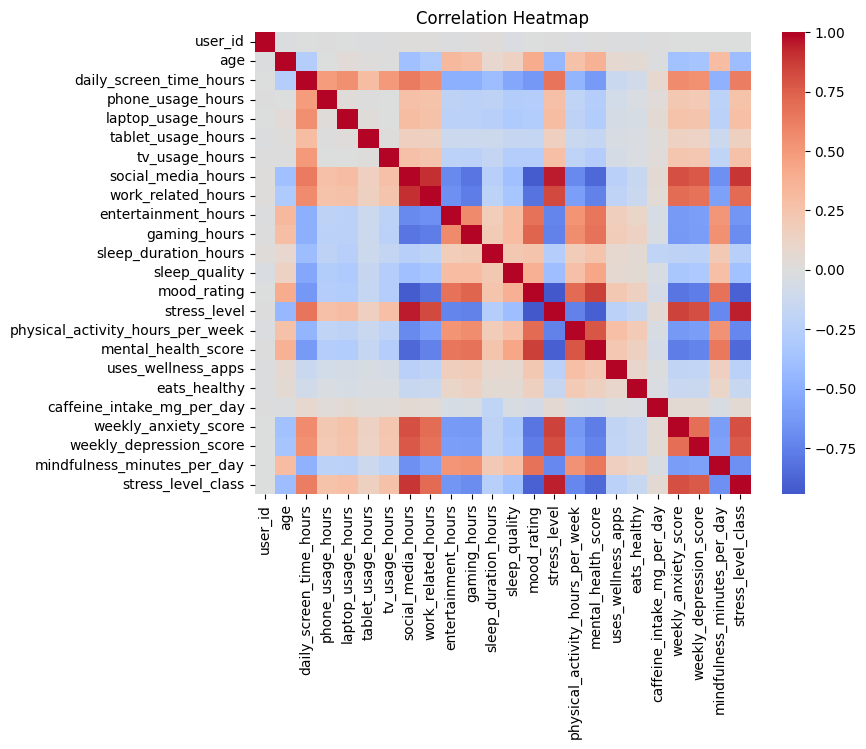

In [ ]:
# Compute correlation matrix
corr = df.corr(numeric_only=True)

# Focus on target correlation
target_corr = corr['stress_level'].sort_values(ascending=False)
print(target_corr)

# Visualize
plt.figure(figsize=(8,6))
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title("Correlation Heatmap")
plt.show()

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# Standardize numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Train models with entire dataset

In [ ]:
# Train MLP
mlp = MLPClassifier(hidden_layer_sizes=(64, 32),
                    activation='relu',
                    solver='adam',
                    max_iter=500,
                    random_state=42)

mlp.fit(X_train_scaled, y_train)

# Predict
y_pred_mlp = mlp.predict(X_test_scaled)

# Evaluate
print("=== MLP Classifier Results ===")
print("Accuracy:", accuracy_score(y_test, y_pred_mlp))
print("\nClassification Report:\n", classification_report(y_test, y_pred_mlp))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_mlp))

=== MLP Classifier Results ===
Accuracy: 0.929

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97       383
           1       0.88      0.88      0.88       293
           2       0.93      0.93      0.93       324

    accuracy                           0.93      1000
   macro avg       0.93      0.93      0.93      1000
weighted avg       0.93      0.93      0.93      1000


Confusion Matrix:
 [[370  13   0]
 [ 12 258  23]
 [  0  23 301]]


In [ ]:
# Train MLP #2 more layers
mlp_deep = MLPClassifier(hidden_layer_sizes=(128, 64, 32),
                         activation='relu',
                         solver='adam',
                         max_iter=600,
                         random_state=42)
mlp_deep.fit(X_train_scaled, y_train)

MLPClassifier(hidden_layer_sizes=(128, 64, 32), max_iter=600, random_state=42)

In [ ]:
# Train MLP #3 more neuron per layer
mlp_wide = MLPClassifier(hidden_layer_sizes=(128, 64),
                         activation='relu',
                         solver='adam',
                         max_iter=600,
                         random_state=42)
mlp_wide.fit(X_train_scaled, y_train)

MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=600, random_state=42)

In [ ]:
# Train XGBoost
xgb = XGBClassifier(
    objective='multi:softmax',
    numclass=3,
    learning_rate=0.1,
    max_depth=6,
    n_estimators=200,
    random_state=42,
    eval_metric='mlogloss')

xgb.fit(X_train, y_train)

# Predict
y_pred_xgb = xgb.predict(X_test)

# Evaluate
print("=== XGBoost Classifier Results ===")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [03:32:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "numclass" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


=== XGBoost Classifier Results ===
Accuracy: 0.951

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       383
           1       0.91      0.92      0.92       293
           2       0.95      0.95      0.95       324

    accuracy                           0.95      1000
   macro avg       0.95      0.95      0.95      1000
weighted avg       0.95      0.95      0.95      1000


Confusion Matrix:
 [[375   8   0]
 [  9 269  15]
 [  0  17 307]]


In [ ]:
# Train Logistic Regression model
lr = LogisticRegression(max_iter=1000, multi_class='multinomial')
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [ ]:
# Train Decision Tree model
dt = DecisionTreeClassifier(max_depth=8, random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

In [ ]:
# Train Random Forest model
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=12,
    random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [ ]:
models = {
    "Baseline MLP": mlp,
    "Deeper MLP (128-64-32)": mlp_deep,
    "Wider MLP (128-64)": mlp_wide,
    "Logistic Regression": lr,
    "Decision Tree": dt,
    "Random Forest": rf,
    "XGBoost": xgb}
rows = []
for name, model in models.items():
    # choose scaled or unscaled inputs
    if name in ["Baseline MLP",
                "Deeper MLP (128-64-32)",
                "Wider MLP (128-64)",
                "Logistic Regression"]:
        X_test_input = X_test_scaled
    else:
        X_test_input = X_test

    y_pred = model.predict(X_test_input)
    rows.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Macro F1": f1_score(y_test, y_pred, average='macro'),
        "Weighted F1": f1_score(y_test, y_pred, average='weighted')})
df_results = pd.DataFrame(rows)
df_results

Model  Accuracy  Macro F1  Weighted F1
0            Baseline MLP     0.929  0.925126     0.929044
1  Deeper MLP (128-64-32)     0.939  0.935673     0.939072
2      Wider MLP (128-64)     0.938  0.934713     0.938235
3     Logistic Regression     0.954  0.951455     0.954017
4           Decision Tree     0.939  0.936170     0.939085
5           Random Forest     0.955  0.952680     0.954999
6                 XGBoost     0.951  0.948275     0.951003

### Train models with selected features

In [ ]:
# Feature importance with XGBoost
xgb_temp = XGBClassifier(
    objective='multi:softmax',
    num_class=3,
    random_state=42,
    eval_metric='mlogloss')
xgb_temp.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=3, ...)

In [ ]:
# Get feature importance and select top 15 features
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_temp.feature_importances_
}).sort_values(by='importance', ascending=False)

top_features = importance_df['feature'][:15].tolist()
print("Top 15 features:", top_features)

Top 15 features: ['social_media_hours', 'mood_rating', 'work_related_hours', 'mental_health_score', 'gender_Other', 'mindfulness_minutes_per_day', 'weekly_anxiety_score', 'weekly_depression_score', 'gaming_hours', 'laptop_usage_hours', 'entertainment_hours', 'daily_screen_time_hours', 'tv_usage_hours', 'physical_activity_hours_per_week', 'eats_healthy']


In [ ]:
# Prepare dataset with top features
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]

In [ ]:
# Standardize numeric features for MLP
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_top)
X_test_scaled = scaler.transform(X_test_top)

In [ ]:
# Train baseline MLP on top features
mlp_top = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', max_iter=500, random_state=42)
mlp_top.fit(X_train_scaled, y_train)
y_pred_mlp = mlp_top.predict(X_test_scaled)

In [ ]:
# Train MLP #2 more layers on top features
mlp_deep_top = MLPClassifier(
    hidden_layer_sizes=(128, 64, 32),
    activation='relu',
    solver='adam',
    max_iter=600,
    random_state=42)
mlp_deep_top.fit(X_train_scaled, y_train)
y_pred_deep = mlp_deep_top.predict(X_test_scaled)

In [ ]:
# Train MLP #3 more neuron per layer on top features
mlp_wide_top = MLPClassifier(
    hidden_layer_sizes=(128, 64),
    activation='relu',
    solver='adam',
    max_iter=600,
    random_state=42)
mlp_wide_top.fit(X_train_scaled, y_train)
y_pred_wide = mlp_wide_top.predict(X_test_scaled)

In [ ]:
# Train Logistics Regresison model on top features
lr_top = LogisticRegression(max_iter=1000, multi_class='multinomial')
lr_top.fit(X_train_scaled, y_train)
y_pred_lr_top = lr_top.predict(X_test_scaled)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [ ]:
# Train Decision Tree model on top features
dt_top = DecisionTreeClassifier(random_state=42)
dt_top.fit(X_train_top, y_train)
y_pred_dt_top = dt_top.predict(X_test_top)

In [ ]:
# Train Random Forest model on top features
rf_top = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42)
rf_top.fit(X_train_top, y_train)
y_pred_rf_top = rf_top.predict(X_test_top)

In [ ]:
# Train XGBoost on top features
xgb_top = XGBClassifier(objective='multi:softmax', num_class=3, learning_rate=0.1, max_depth=6,
                    n_estimators=200, random_state=42, eval_metric='mlogloss')
xgb_top.fit(X_train_top, y_train)
y_pred_xgb = xgb_top.predict(X_test_top)

In [ ]:
# Models to compare
models = {
    "Baseline MLP": mlp_top,
    "Deeper MLP": mlp_deep_top,
    "Wider MLP": mlp_wide_top,
    "Logistic Regression": lr_top,
    "Decision Tree": dt_top,
    "Random Forest": rf_top,
    "XGBoost": xgb_top}
results = []
for name, model in models.items():
    X_test_input = X_test_scaled if name in ["Baseline MLP", "Deeper MLP", "Wider MLP", "Logistic Regression"] else X_test_top
    y_pred = model.predict(X_test_input)
    results.append([
        name,
        accuracy_score(y_test, y_pred),
        f1_score(y_test, y_pred, average='macro'),
        f1_score(y_test, y_pred, average='weighted')])
# Convert to DataFrame
df_results = pd.DataFrame(results, columns=["Model", "Accuracy", "Macro F1", "Weighted F1"])
df_results

Model  Accuracy  Macro F1  Weighted F1
0         Baseline MLP     0.948  0.944812     0.947838
1           Deeper MLP     0.934  0.929888     0.933764
2            Wider MLP     0.944  0.940765     0.944000
3  Logistic Regression     0.958  0.955610     0.957938
4        Decision Tree     0.930  0.926526     0.930043
5        Random Forest     0.954  0.951461     0.953955
6              XGBoost     0.950  0.947124     0.949951

## Apply SHAP and LIME (top features)

### Explanation using LIME

In [ ]:
# User and true label
i = 0
true_label = y_test.iloc[i]
class_map = {0: "Low", 1: "Medium", 2: "High"}
true_label_name = class_map[true_label]

In [ ]:
print("XGBoost LIME Explanation (sample {})".format(i))
print("True Label :", true_label, true_label_name)
# Create LIME explainer for XGBoost
lime_explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train_top),
    feature_names=X_train_top.columns,
    class_names=['Low', 'Medium', 'High'],
    mode='classification')
# Explain one sample prediction
pred_class = xgb.predict(X_test_top.iloc[i].values.reshape(1, -1))[0]
exp_xgb = lime_explainer.explain_instance(
    data_row=X_test_top.iloc[i].values,
    predict_fn=xgb.predict_proba,
    num_features=10,
    labels=[pred_class])
exp_xgb.show_in_notebook(show_table=True)

XGBoost LIME Explanation (sample 0)
True Label : 2 High


In [ ]:
print("MLP LIME Explanation (sample {})".format(i))
print("True Label :", true_label, true_label_name)
# MLP predicted class
mlp_pred_class = mlp_top.predict(X_test_scaled[i:i+1])[0]
# Create explainer for MLP (use scaled training data!)
lime_explainer_mlp = lime_tabular.LimeTabularExplainer(
    training_data=X_train_scaled,
    feature_names=X_train_top.columns,
    class_names=['Low', 'Medium', 'High'],
    mode='classification')
# Explain MLP
exp_mlp = lime_explainer_mlp.explain_instance(
    data_row=X_test_scaled[i],
    predict_fn=mlp_top.predict_proba,
    num_features=10,
    labels=[mlp_pred_class])
exp_mlp.show_in_notebook(show_table=True)

MLP LIME Explanation (sample 0)
True Label : 2 High


### Explanation using SHAP

PermutationExplainer explainer: 1001it [13:41,  1.20it/s]
/tmp/ipython-input-1112242488.py:10: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_xgb, X_test_array_xgb, feature_names=X_test_top.columns, plot_type="bar")


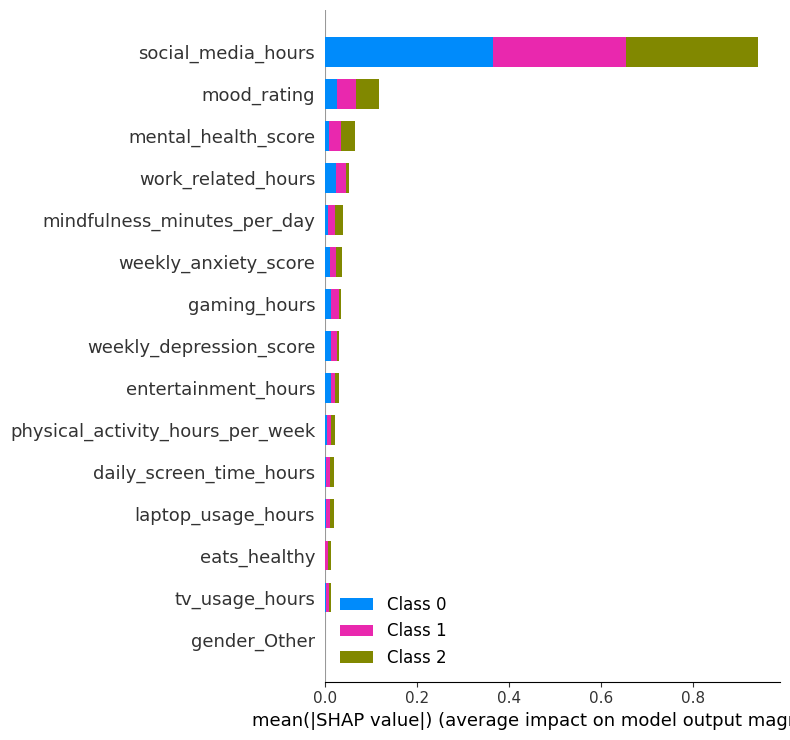

In [ ]:
# SHAP for XGB
X_train_array_xgb = np.array(X_train_top, dtype=float)
X_test_array_xgb  = np.array(X_test_top, dtype=float)

# Use model's prediction function
explainer_xgb = shap.Explainer(xgb.predict_proba, X_train_array_xgb)
shap_values_xgb = explainer_xgb(X_test_array_xgb)

# Global explanation
shap.summary_plot(shap_values_xgb, X_test_array_xgb, feature_names=X_test_top.columns, plot_type="bar")

PermutationExplainer explainer: 1001it [01:37,  9.98it/s]
/tmp/ipython-input-158821333.py:12: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


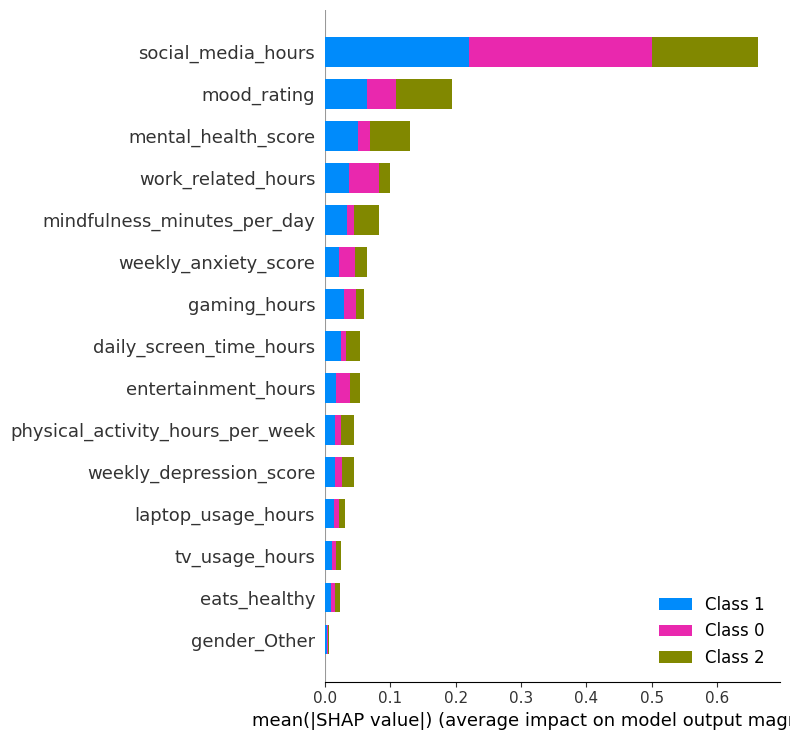

In [ ]:
# SHAP for MLP
X_train_array_mlp = np.array(X_train_scaled, dtype=float)
X_test_array_mlp  = np.array(X_test_scaled, dtype=float)

# Create SHAP explainer for MLP
explainer_mlp = shap.Explainer(mlp_top.predict_proba, X_train_array_mlp)

# Compute SHAP values
shap_values_mlp = explainer_mlp(X_test_array_mlp)

# Global feature importance (bar plot)
shap.summary_plot(
    shap_values_mlp,
    X_test_array_mlp,
    feature_names=X_train_top.columns,
    plot_type="bar")

## Results Analysis

Define subgroups and compute fairness/robustness metrics


/tmp/ipython-input-3815258280.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for g, idx in group.groupby(group).groups.items():


group      value    n  accuracy  f1_macro  auc_macro  TPR_macro  \
3   age_bin    [0, 18)   48  0.979167  0.965681        NaN   0.944444   
4   age_bin   [18, 30)  207  0.951691  0.949301        NaN   0.958514   
5   age_bin   [30, 50)  340  0.950000  0.946290        NaN   0.947625   
6   age_bin  [50, 100)  405  0.945679  0.936197        NaN   0.937655   
0    gender     Female  486  0.948560  0.946583        NaN   0.946534   
1    gender       Male  480  0.950000  0.945850        NaN   0.946133   
2    gender      Other   34  0.970588  0.970794        NaN   0.974359   
7  location      Rural  214  0.943925  0.942385        NaN   0.942211   
8  location   Suburban  292  0.931507  0.925865        NaN   0.925074   
9  location      Urban  494  0.963563  0.961890        NaN   0.962315   

   FPR_macro  
3   0.047619  
4   0.027475  
5   0.024859  
6   0.027478  
0   0.025455  
1   0.024290  
2   0.013889  
7   0.027871  
8   0.033652  
9   0.017864

accuracy  f1_macro  auc_macro  TPR_macro  FPR_macro
group                                                        
age_bin   0.033488  0.029484        NaN   0.020858   0.022760
gender    0.022029  0.024944        NaN   0.028226   0.011566
location  0.032056  0.036025        NaN   0.037241   0.015788

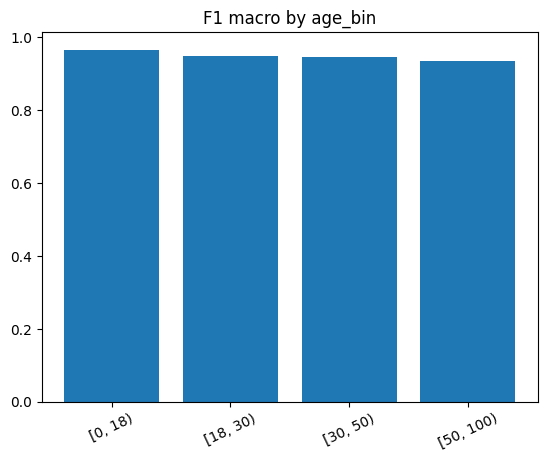

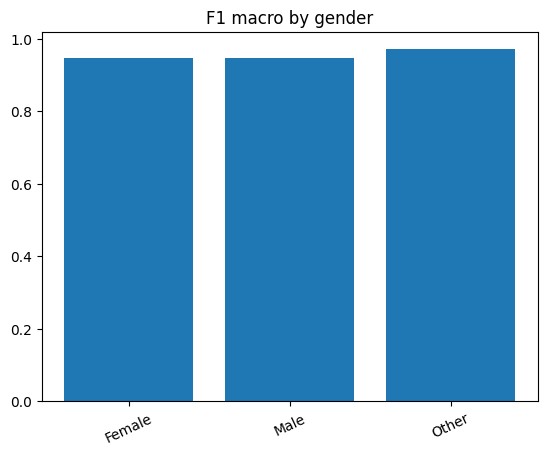

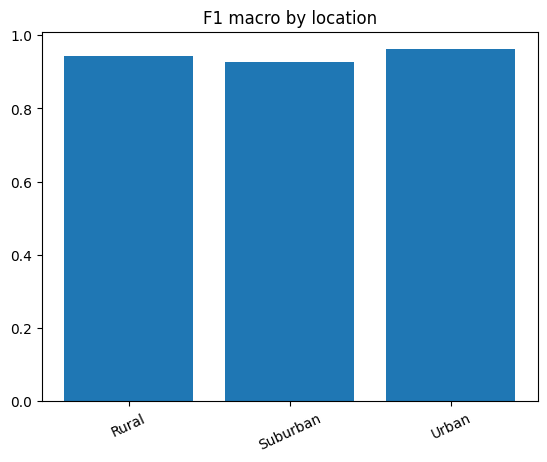

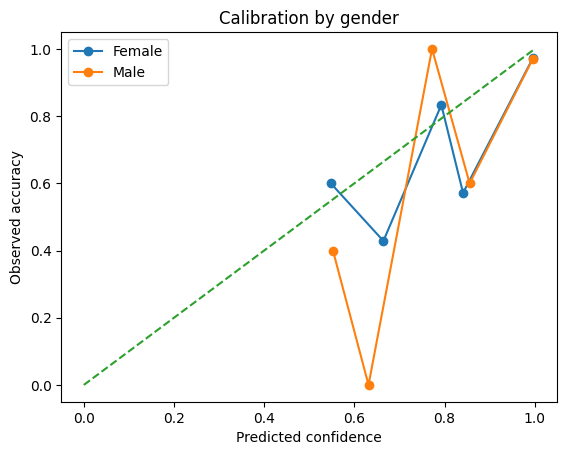

In [ ]:
import numpy as np, pandas as pd
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, confusion_matrix,
    precision_recall_fscore_support, brier_score_loss
)
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve


y_proba_xgb = xgb.predict_proba(X_test_top)
y_pred_xgb = np.argmax(y_proba_xgb, axis=1)


classes_ = np.sort(np.unique(y_test))

# Choose subgroups I care about - can be edit
subgroups = {
    "gender": df.loc[X_test.index, "gender"],
    "age_bin": pd.cut(df.loc[X_test.index, "age"], [0,18,30,50,100], right=False),
    "location": df.loc[X_test.index, "location_type"],         # e.g., 'urban','suburban','rural'
}

def subgroup_report(y_true, y_pred, y_proba, group, group_name):
    rows = []
    for g, idx in group.groupby(group).groups.items():
        yt = y_true.loc[idx]
        yp = pd.Series(y_pred, index=y_true.index).loc[idx]
        # macro metrics
        acc = accuracy_score(yt, yp)
        f1m = f1_score(yt, yp, average='macro')
        # one-vs-rest macro AUC if probs available
        try:
            aucm = roc_auc_score(pd.get_dummies(yt, columns=classes_), y_proba[idx], average='macro', multi_class='ovr')
        except Exception:
            aucm = np.nan
        # error rates for “fairness-style” gaps on each class vs rest (TPR/FPR)
        cm = confusion_matrix(yt, yp, labels=classes_)
        # for multi-class, report macro TPR/FPR
        tpr = np.mean(np.diag(cm) / cm.sum(axis=1).clip(min=1))
        fpr = np.mean((cm.sum(axis=0) - np.diag(cm)) / (cm.sum() - cm.sum(axis=1)).clip(min=1))
        rows.append([group_name, g, len(idx), acc, f1m, aucm, tpr, fpr])
    out = pd.DataFrame(rows, columns=["group","value","n","accuracy","f1_macro","auc_macro","TPR_macro","FPR_macro"])
    return out

# Build the table
sg_tables = []
sg_tables.append(subgroup_report(pd.Series(y_test), y_pred_xgb, y_proba_xgb, subgroups["gender"], "gender"))
sg_tables.append(subgroup_report(pd.Series(y_test), y_pred_xgb, y_proba_xgb, subgroups["age_bin"], "age_bin"))
sg_tables.append(subgroup_report(pd.Series(y_test), y_pred_xgb, y_proba_xgb, subgroups["location"], "location"))
sg_table = pd.concat(sg_tables, ignore_index=True).sort_values(["group","value"])
display(sg_table)

# Quick gap view (max – min across each subgroup)
gap = sg_table.groupby("group")[["accuracy","f1_macro","auc_macro","TPR_macro","FPR_macro"]].agg(lambda s: s.max()-s.min())
display(gap)

# Bar plot of F1 by subgroup
for grp in sg_table["group"].unique():
    tmp = sg_table[sg_table["group"]==grp]
    plt.figure()
    plt.bar(tmp["value"].astype(str), tmp["f1_macro"])
    plt.title(f"F1 macro by {grp}")
    plt.xticks(rotation=25)
    plt.show()

# Reliability (calibration) per subgroup (for one class or “max class”)
def plot_calibration_by_group(y_true, y_proba, group, title="Calibration"):
    # use max probability as confidence for multi-class
    conf = y_proba.max(axis=1)
    correct = (y_true.values == y_proba.argmax(axis=1)).astype(int)
    for g in group.unique():
        idx = (group==g).values
        if idx.sum() < 50:
            continue
        prob_true, prob_pred = calibration_curve(correct[idx], conf[idx], n_bins=10, strategy="uniform")
        plt.plot(prob_pred, prob_true, marker='o', label=str(g))
    plt.plot([0,1],[0,1], linestyle='--')
    plt.title(title); plt.xlabel("Predicted confidence"); plt.ylabel("Observed accuracy"); plt.legend(); plt.show()

plot_calibration_by_group(pd.Series(y_test), y_proba_xgb, subgroups["gender"], "Calibration by gender")


In [ ]:
print("Features:", len(X_test_top.columns))
print("Full SHAP shape:", np.ravel(full_importance).shape)
print("Sample SHAP shape:", np.ravel(sample_importance).shape)


Features: 15
Full SHAP shape: (45,)
Sample SHAP shape: (45,)


In [ ]:
import numpy as np
import pandas as pd

# ================================================
# EXPLAINABILITY EVALUATION ANALYSIS
# ================================================

n_features = len(X_test_top.columns)  # 15
n_classes = 45 // n_features          # 3 class

# turn full_importance and sample_importance into matrix (n_classes x n_features)
full_importance_matrix = np.ravel(full_importance).reshape(n_classes, n_features)
sample_importance_matrix = np.ravel(sample_importance).reshape(n_classes, n_features)

# count average shap for each feature
full_importance_mean = full_importance_matrix.mean(axis=0)
sample_importance_mean = sample_importance_matrix.mean(axis=0)

# creat DataFrame
shap_df = pd.DataFrame({
    'Feature': X_test_top.columns,
    'Full_SHAP': full_importance_mean,
    'Sample_SHAP': sample_importance_mean
})


shap_df['Spearman_corr'] = shap_df[['Full_SHAP', 'Sample_SHAP']].corr(method='spearman').iloc[0,1]
print(shap_df)

                             Feature  Full_SHAP  Sample_SHAP  Spearman_corr
0                 social_media_hours   0.127770     0.125139          0.975
1                        mood_rating   0.105244     0.098751          0.975
2                 work_related_hours   0.104629     0.104563          0.975
3                mental_health_score   0.013035     0.015071          0.975
4                       gender_Other   0.021452     0.021298          0.975
5        mindfulness_minutes_per_day   0.024057     0.023916          0.975
6               weekly_anxiety_score   0.013442     0.014447          0.975
7            weekly_depression_score   0.013072     0.013105          0.975
8                       gaming_hours   0.006126     0.005614          0.975
9                 laptop_usage_hours   0.008917     0.010268          0.975
10               entertainment_hours   0.017168     0.017452          0.975
11           daily_screen_time_hours   0.015107     0.014882          0.975
12          

In [ ]:
exp.as_list()


[('3.60 < social_media_hours <= 4.50', 0.5683740594047665),
 ('mood_rating <= 1.70', -0.08914369664038839),
 ('entertainment_hours <= 1.20', 0.07040509626518028),
 ('1.00 < gaming_hours <= 1.40', 0.0428604437182375),
 ('weekly_anxiety_score > 12.00', -0.029095681886081654),
 ('12.40 < mindfulness_minutes_per_day <= 17.10', -0.02654967324397601),
 ('mental_health_score <= 54.00', -0.021874973000420628),
 ('1.40 < tv_usage_hours <= 2.10', 0.02041553000045991),
 ('physical_activity_hours_per_week <= 0.60', -0.014641055690304883),
 ('3.10 < work_related_hours <= 3.70', -0.014212463402536497)]

                             Feature  Full_SHAP  Sample_SHAP      LIME
0                 social_media_hours   0.313858     0.305275  0.568374
1                        mood_rating   0.039439     0.041219  0.089144
3                mental_health_score   0.021684     0.022068  0.021875
2                 work_related_hours   0.017761     0.017978  0.014212
5        mindfulness_minutes_per_day   0.013205     0.012747  0.026550
6               weekly_anxiety_score   0.012329     0.011690  0.029096
8                       gaming_hours   0.011873     0.013323  0.042860
10               entertainment_hours   0.010580     0.010431  0.070405
7            weekly_depression_score   0.010467     0.010943  0.000000
13  physical_activity_hours_per_week   0.007635     0.007212  0.014641


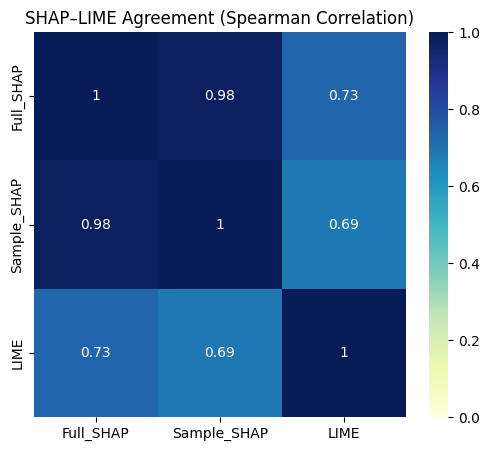

<Figure size 1000x500 with 0 Axes>

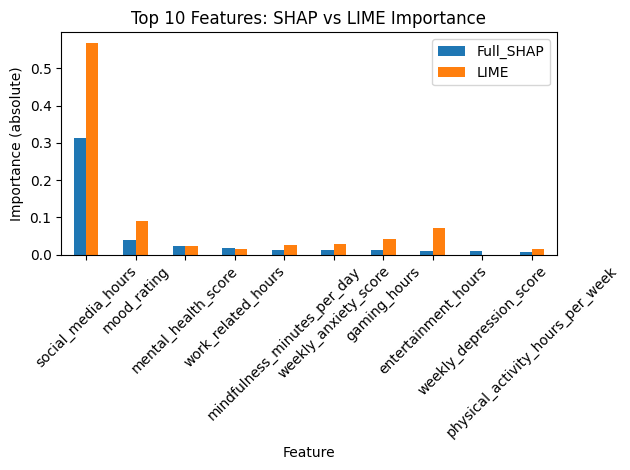

In [ ]:
from collections import defaultdict

# --- Extract feature-level LIME importance properly ---
lime_dict = defaultdict(float)
for f, w in exp.as_list():
    # devide LIME to extract the real feature name
    for col in X_test_top.columns:
        if col in f:
            lime_dict[col] += w  # counting if feature appear many time

# create importance list follow the order of column
lime_importance_aligned = np.array([abs(lime_dict.get(col, 0.0)) for col in X_test_top.columns])

# --- DataFrame: SHAP + LIME ---
shap_lime_df = pd.DataFrame({
    'Feature': X_test_top.columns,
    'Full_SHAP': np.abs(full_importance),
    'Sample_SHAP': np.abs(sample_importance),
    'LIME': lime_importance_aligned
})

# --- check top features ---
top_features = shap_lime_df.sort_values('Full_SHAP', ascending=False).head(10)
print(top_features)

# --- Correlation heatmap ---
plt.figure(figsize=(6,5))
sns.heatmap(shap_lime_df[['Full_SHAP','Sample_SHAP','LIME']].corr(method='spearman'),
            annot=True, cmap='YlGnBu', vmin=0, vmax=1)
plt.title('SHAP–LIME Agreement (Spearman Correlation)')
plt.show()

# --- Top feature comparison ---
plt.figure(figsize=(10,5))
top_features.plot(x='Feature', y=['Full_SHAP','LIME'], kind='bar')
plt.title('Top 10 Features: SHAP vs LIME Importance')
plt.ylabel('Importance (absolute)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


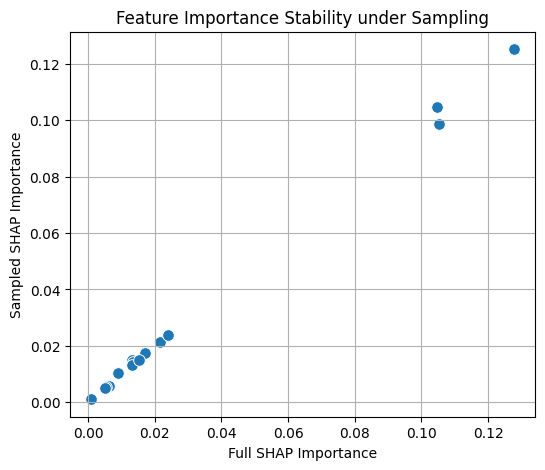

In [ ]:
# ---- 4. Stability Scatter Plot ----
plt.figure(figsize=(6,5))
sns.scatterplot(x='Full_SHAP', y='Sample_SHAP', data=shap_df, s=70)
plt.xlabel("Full SHAP Importance")
plt.ylabel("Sampled SHAP Importance")
plt.title("Feature Importance Stability under Sampling")
plt.grid(True)
plt.show()



In [ ]:
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

# Copy test set to create "zeroed" version (turn off feature top)
X_test_zero = X_test_top.copy()

# extract top 3 most important features from SHAP
top3_idx = np.argsort(full_importance)[-3:]
X_test_zero.iloc[:, top3_idx] = 0

# Faithfulness test: check how accuracy decreases
acc_before = accuracy_score(y_test, xgb.predict(X_test_top))
acc_after = accuracy_score(y_test, xgb.predict(X_test_zero))

print(f"Faithfulness test — accuracy drop: {acc_before:.3f} → {acc_after:.3f} (-{(acc_before-acc_after)*100:.1f}%)")



Faithfulness test — accuracy drop: 0.950 → 0.399 (-55.1%)
